# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
import torch
import numpy as np

In [2]:
torch.__version__

'1.7.1'

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

This cell will create DataLoaders for each of our datasets.

In [3]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Morzilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Number of subprocesses to use for data loading
num_workers = 0
# Batch-size, smaples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# transformations, convert data to torch.FloatTensor
transform = transforms.ToTensor()

# Choose the training and test datasets
train_data = datasets.MNIST(root='data', 
                            train=True,
                            download=True,
                            transform=transform)
test_data =  datasets.MNIST(root='data', 
                            train=False,
                            download=True,
                            transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_sampler,
                                           num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = valid_sampler,
                                           num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

<ipython-input-6-354f5f1dbf7e>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


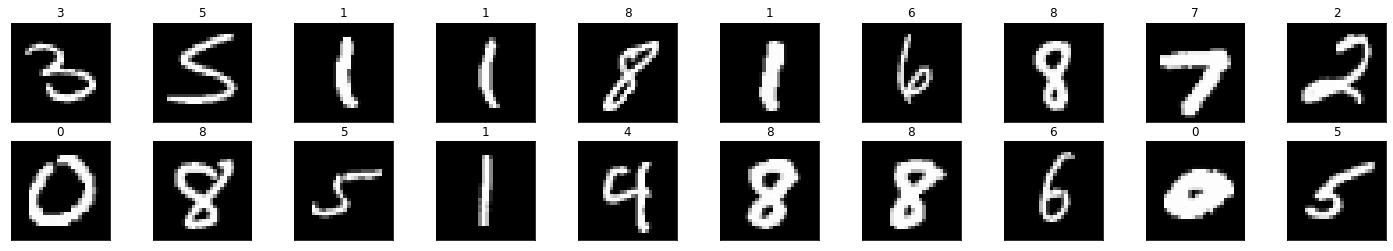

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images from tensors to numpy array
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

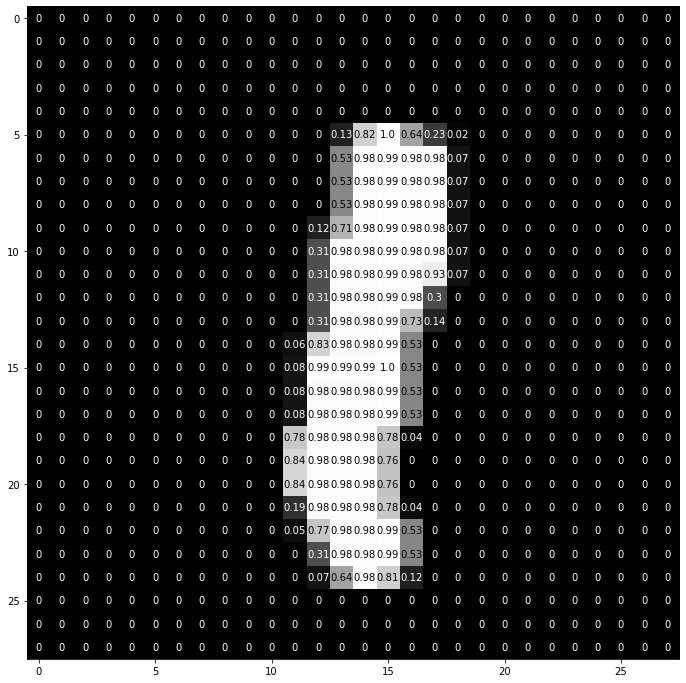

In [7]:
img = np.squeeze(images[5]) # any one sample image

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width,height = img.shape
threshold = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<threshold else 'black')

## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
# Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layers
        ## fullyconnected linear layer 1 (784 -> 512)
        self.fc1 = nn.Linear(28*28, 512)
        ## fullyconnected linear layer 2 (512 -> 512)
        self.fc2 = nn.Linear(512, 512)
        ## fullyconnected linear layer 1 (512 -> 10)
        self.fc3 = nn.Linear(512, 10)
        ## Dropout layer with a dropout rate of 20%
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
# Initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

`CrossEntropyLoss()` is used for classification in this problem. The Cross Entropy function applies softmax funtion `LogSoftmax()` to the output layer *and* then calculates the log loss. (Negative log likelihood loss - `NLLLoss()` )

In [10]:
# Specify loss funtion
criterion = nn.CrossEntropyLoss()
# Specify Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [15]:
# number of epochs to train the model
n_epochs = 100
# loss
loss_dict = { 'epochs':n_epochs, 'training':[], 'validation':[]}

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    # put model object in training mode
    model.train()
    for data, target in train_loader:
        # clear residual gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # Calulate loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################
    # validate the model #
    #####################
    # put model in evaluation mode
    model.eval()
    for data,target in valid_loader:
        # forward pass
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        # update running validation loss
        valid_loss += loss.item()
    
    # Print training and validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    loss_dict['training'].append(train_loss)
    ##
    valid_loss = valid_loss/len(valid_loader)
    loss_dict['validation'].append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    train_loss, 
    valid_loss
        ))

Epoch: 1 	Training Loss: 0.173275 	Validation Loss: 0.072151
Epoch: 2 	Training Loss: 0.180673 	Validation Loss: 0.073222
Epoch: 3 	Training Loss: 0.170470 	Validation Loss: 0.071506
Epoch: 4 	Training Loss: 0.169157 	Validation Loss: 0.071434
Epoch: 5 	Training Loss: 0.164801 	Validation Loss: 0.073985
Epoch: 6 	Training Loss: 0.164058 	Validation Loss: 0.072523
Epoch: 7 	Training Loss: 0.155625 	Validation Loss: 0.073031
Epoch: 8 	Training Loss: 0.142002 	Validation Loss: 0.074034
Epoch: 9 	Training Loss: 0.150512 	Validation Loss: 0.073295
Epoch: 10 	Training Loss: 0.153645 	Validation Loss: 0.071989
Epoch: 11 	Training Loss: 0.142902 	Validation Loss: 0.071597
Epoch: 12 	Training Loss: 0.144769 	Validation Loss: 0.073353
Epoch: 13 	Training Loss: 0.137011 	Validation Loss: 0.075439
Epoch: 14 	Training Loss: 0.128657 	Validation Loss: 0.074456
Epoch: 15 	Training Loss: 0.127031 	Validation Loss: 0.072143
Epoch: 16 	Training Loss: 0.130579 	Validation Loss: 0.074429
Epoch: 17 	Traini

Using `len(train_loader.dataset)` and `len(valid_loader.dataset)` will result in wrong values as they return size of `train_data` (i.e 60000 images). This is the reason for such difference in `train_loss` and `valid_loss`.

`train_loader` actually has size of 0.8*`train_data` (i.e 48000 images) and `valid_loader` actually has size of 0.2*`train_data` (i.e 12000 images). 

Hence calculate average batch loss in each batch and divide by total batches. This works because all the batches in both the dataloaders are of 20. 

`(reason: 48000%20=0 and 12000%20=0)`

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

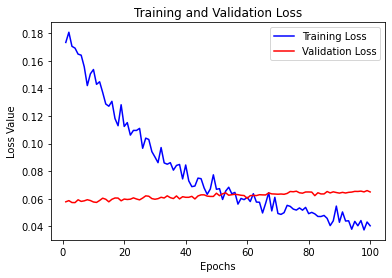

Plot after re-sizing: 


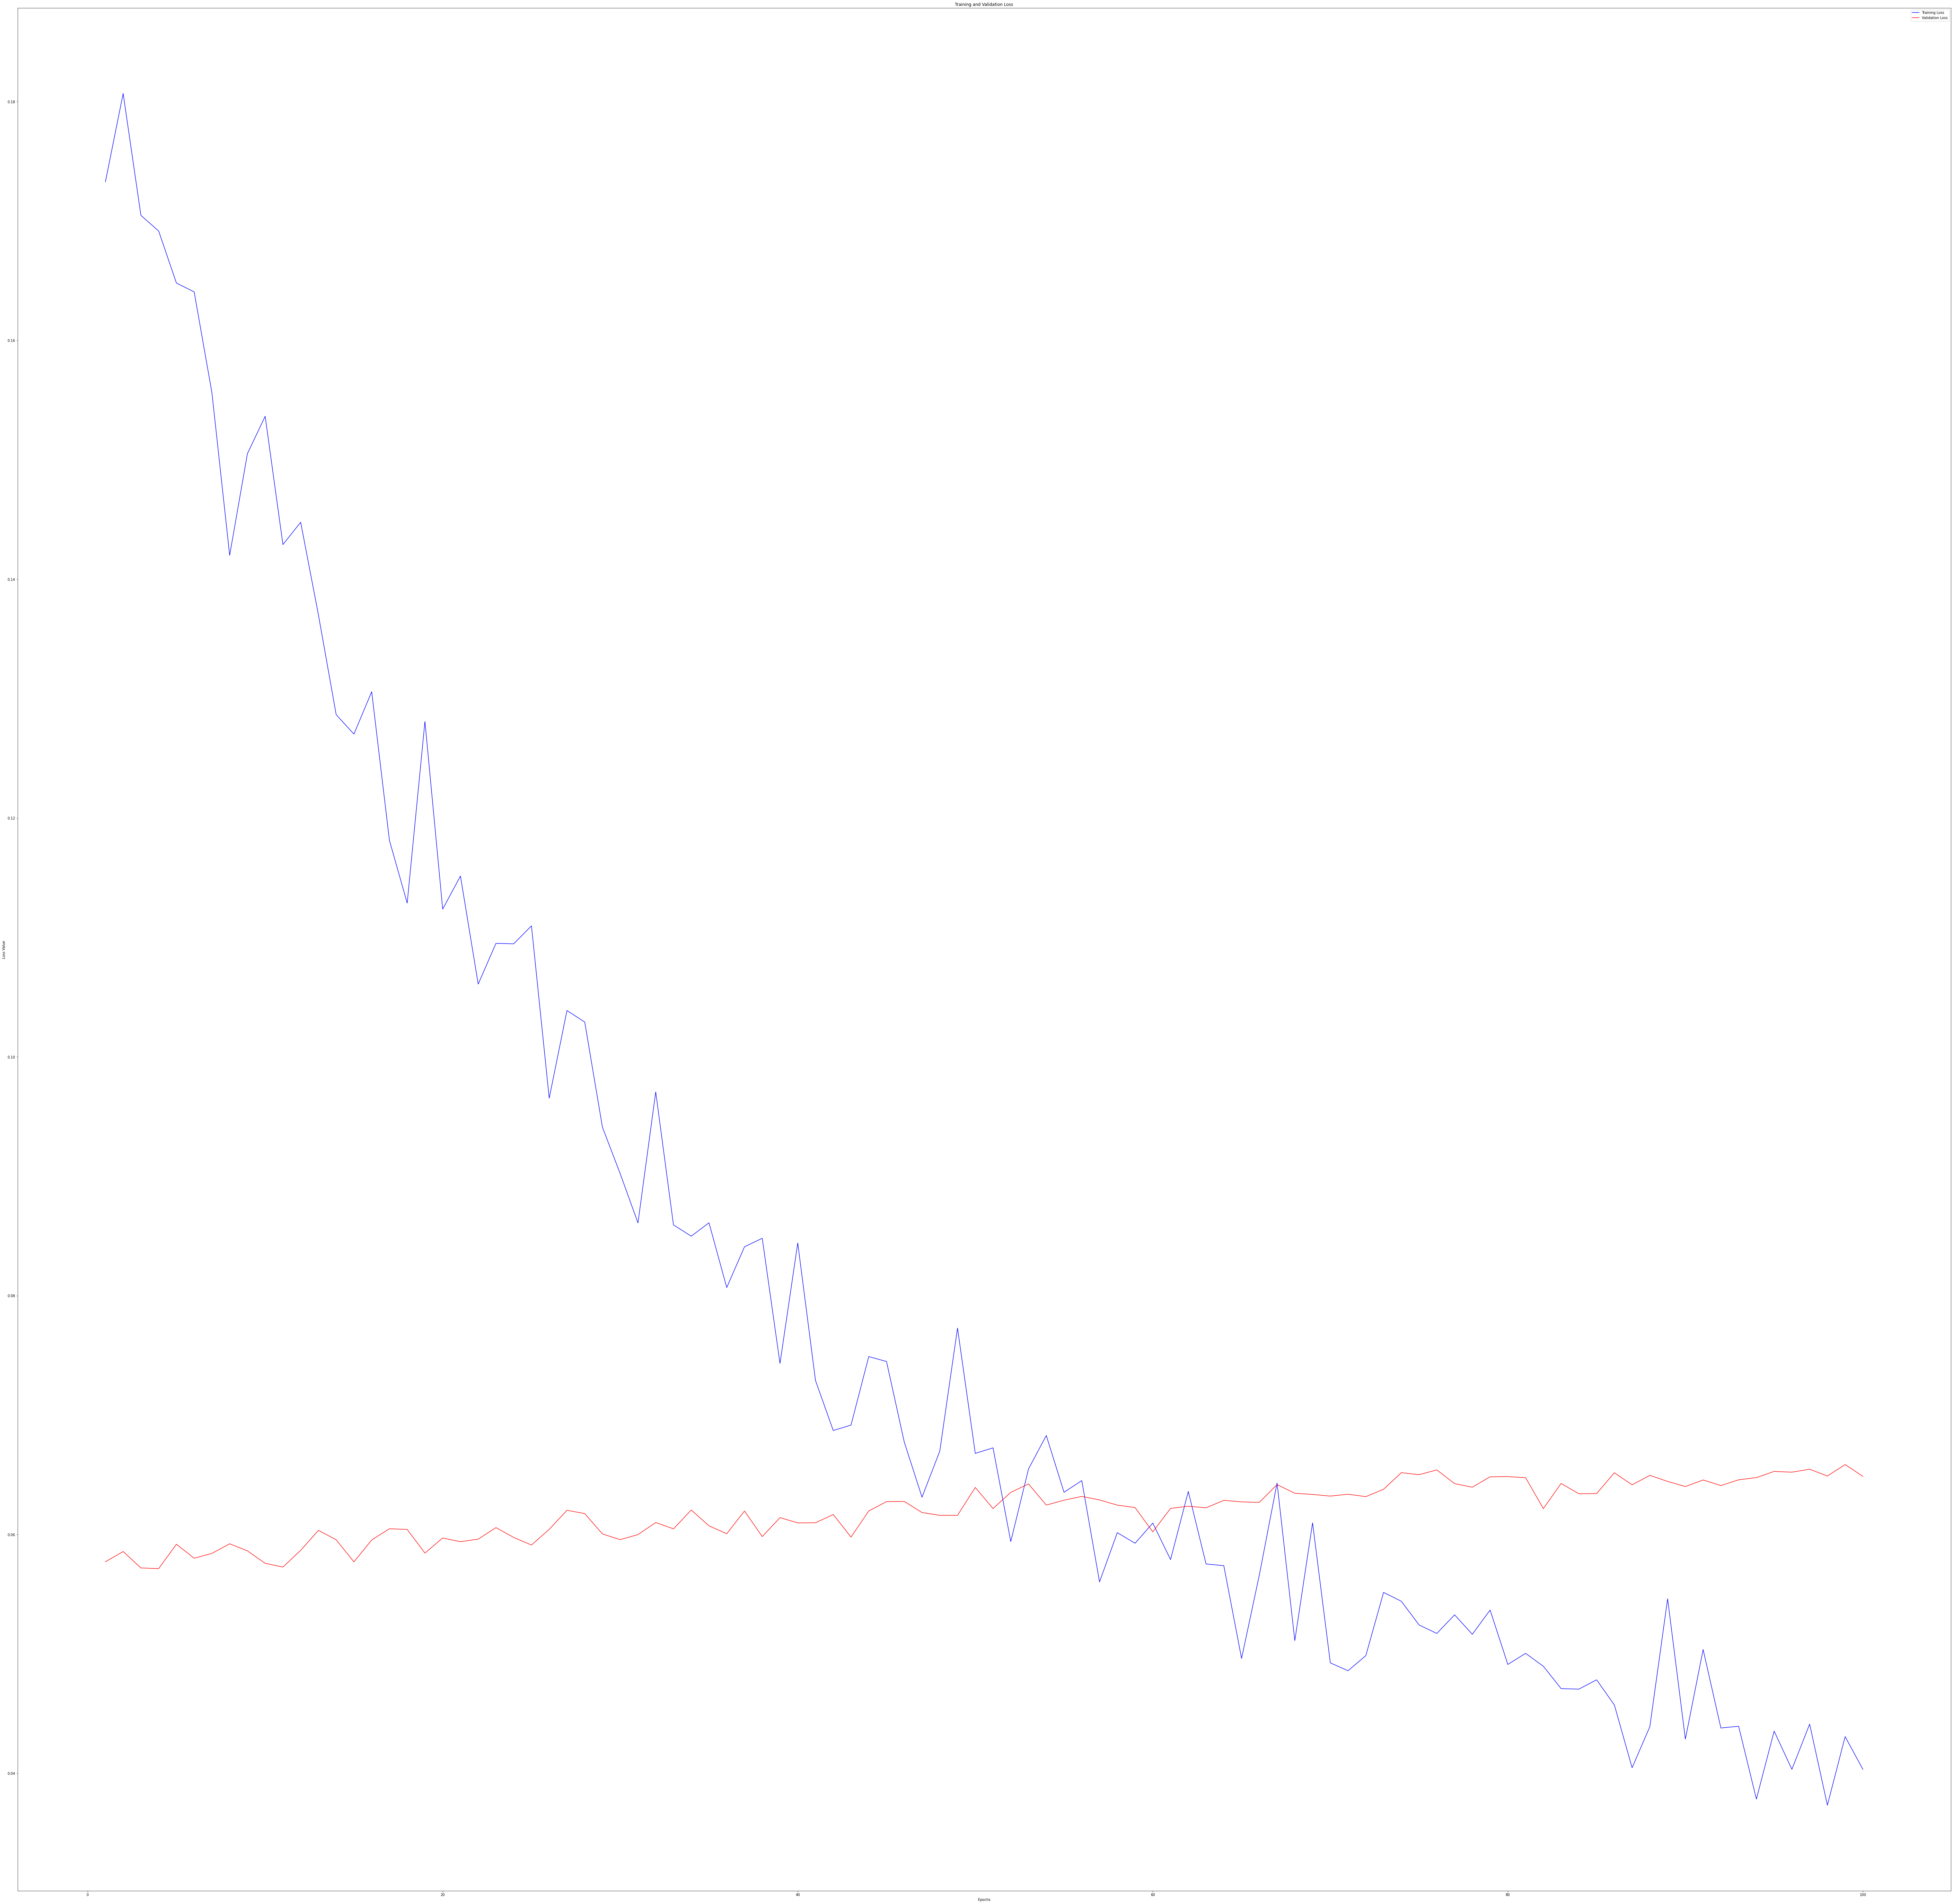

In [31]:
# plotting losses
epochs = range(1, loss_dict['epochs']+1)

plt.plot(epochs, loss_dict['training'], 'b', label="Training Loss")
plt.plot(epochs, loss_dict['validation'], 'r', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

###############
# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(100)
  
print("Plot after re-sizing: ")
plt.plot(epochs, loss_dict['training'], 'b', label="Training Loss")
plt.plot(epochs, loss_dict['validation'], 'r', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

### Automatic saving model at minimum validation loss

The model is saved continuously for as long as the validation loss continues to decrease. Once the validation loss begins to increase and the model begins to overfit, it is no longer saved.

This is different from automatic stopping and is inefficient and compute-expensive because the model continues to train for the given number of epochs, i.e. `n_epochs`. If the minimum validation loss is achived at epochs less than `n_epochs` the final model is overfitted.

In [34]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# monitoring loss
loss_dict = { 'epochs':n_epochs, 'training':[], 'validation':[]}

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    
    ###################
    # train the model #
    ###################
    # put model object in training mode
    model.train()
    for data, target in train_loader:
        # clear residual gradients of all optimized variables
        optimizer.zero_grad()
        # foward pass
        output = model(data)
        # Calulate loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################
    # validate the model #
    #####################
    # put model in evaluation mode
    model.eval()
    for data,target in valid_loader:
        # forward pass
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        # update running validation loss
        valid_loss += loss.item()
    
    # Print training and validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    loss_dict['training'].append(train_loss)
    ##
    valid_loss = valid_loss/len(valid_loader)
    loss_dict['validation'].append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    train_loss, 
    valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pth')
        valid_loss_min = valid_loss
        min_epoch = epoch+1
        
print('\nModel saved at {} epochs.'.format(min_epoch))

Epoch: 1 	Training Loss: 0.025355 	Validation Loss: 0.083915
Validation loss decreased (inf --> 0.083915). Saving model...
Epoch: 2 	Training Loss: 0.035155 	Validation Loss: 0.084578
Epoch: 3 	Training Loss: 0.029953 	Validation Loss: 0.082981
Validation loss decreased (0.083915 --> 0.082981). Saving model...
Epoch: 4 	Training Loss: 0.032355 	Validation Loss: 0.083760
Epoch: 5 	Training Loss: 0.032092 	Validation Loss: 0.085298
Epoch: 6 	Training Loss: 0.029685 	Validation Loss: 0.084208
Epoch: 7 	Training Loss: 0.029352 	Validation Loss: 0.086711
Epoch: 8 	Training Loss: 0.030736 	Validation Loss: 0.082547
Validation loss decreased (0.082981 --> 0.082547). Saving model...
Epoch: 9 	Training Loss: 0.028665 	Validation Loss: 0.083201
Epoch: 10 	Training Loss: 0.031109 	Validation Loss: 0.084634
Epoch: 11 	Training Loss: 0.033195 	Validation Loss: 0.083712
Epoch: 12 	Training Loss: 0.030146 	Validation Loss: 0.082873
Epoch: 13 	Training Loss: 0.030342 	Validation Loss: 0.083406
Epoch: 

### Load the model with the Lowest Validation Loss

In [35]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [36]:
# initialize lists to monitor tess loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Set model object in evaluation mode, this turns off dropout
model.eval()

for data, target in test_loader:
    # forward pass
    output = model(data)
    # calculate loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilites to predicted class
    _, pred = torch.max(output, 1)
    # compare predicts to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # claculate test_accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.066459

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1017/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 98% (1008/1028)
Test Accuracy of     8: 96% (942/974)
Test Accuracy of     9: 98% (995/1009)

Test Accuracy (Overall): 98% (9838/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

<ipython-input-37-48bf1d79b703>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


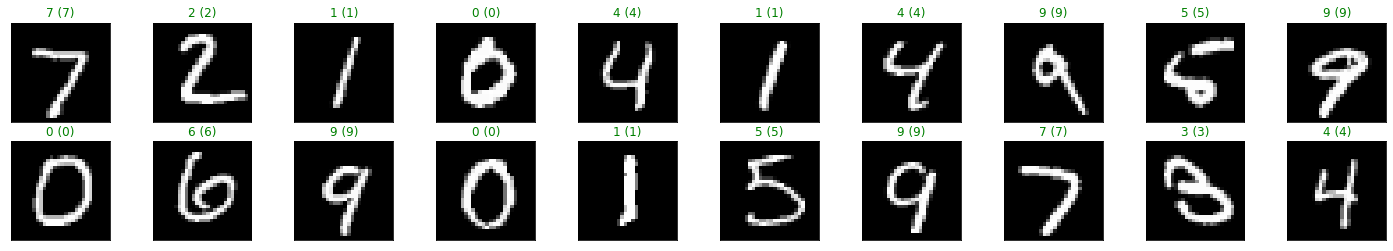

In [37]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))